In [2]:
import sys

# installation captum sans bloquer sur les versions
!{sys.executable} -m pip install captum --no-deps

# on laisse numpy tranquille pour eviter le blocage
print("installation terminee.")

installation terminee.


In [3]:
import torch
import numpy as np
from captum.attr import LayerGradCam, visualization as vit

# verification chargement captum
print("SUCCES : Captum est charge et pret !")
print(f"Version Numpy : {np.__version__}")

SUCCES : Captum est charge et pret !
Version Numpy : 2.2.6


In [4]:
import os

# chemin projet windows
project_path = r"C:\Users\amisf\Desktop\datascientest_projet"

try:
    os.chdir(project_path)
    print(f"Deplacement reussi vers : {os.getcwd()}")
except FileNotFoundError:
    print("Erreur : Chemin introuvable.")

# verification presence fichier mapping
if os.path.exists('models/category_mapping.json'):
    print("BINGO ! Fichier mapping trouve.")
else:
    print("Attention : fichier mapping introuvable.")

Deplacement reussi vers : C:\Users\amisf\Desktop\datascientest_projet
BINGO ! Fichier mapping trouve.


In [5]:
import torch, timm, joblib, json, os
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torch import nn
from torchvision import models, transforms
from captum.attr import LayerGradCam, visualization as vit

# reglage device gpu ou cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# chargement mapping utf8
with open('models/category_mapping.json', 'r', encoding='utf-8') as f:
    mapping = json.load(f)

# definition chemin modeles
MODELS_DIR = "models/"

print(f"Imports OK. Device: {device}")
print(f"Mapping charge: {len(mapping)} categories.")

# creation dictionnaire modeles
models_dict = {}

# m1 dinov3
print("Chargement DINOv3...")
try:
    m1 = timm.create_model('vit_large_patch14_reg4_dinov2.lvd142m', pretrained=False, num_classes=27)
    m1.load_state_dict(torch.load(MODELS_DIR+"M1_IMAGE_DeepLearning_DINOv3.pth", map_location=device))
    models_dict['DINOv3'] = m1.to(device).eval()
    print("   -> OK")
except Exception as e: print(f"   -> Echec DINO: {e}")

# m2 xgboost
print("Chargement XGBoost...")
try:
    m2_xgb = xgb.XGBClassifier()
    m2_xgb.load_model(MODELS_DIR+"M2_IMAGE_Classic_XGBoost.json")
    
    # extracteur resnet pour xgboost
    res = models.resnet50(weights=None)
    ext = nn.Sequential(*list(res.children())[:-1]).to(device).eval()
    print("   -> OK")
except Exception as e: print(f"   -> Echec XGBoost: {e}")

# m3 efficientnet
print("Chargement EfficientNet...")
try:
    m3 = models.efficientnet_b0(weights=None)
    m3.classifier[1] = nn.Linear(1280, 27)
    m3.load_state_dict(torch.load(MODELS_DIR+"M3_IMAGE_Classic_EfficientNetB0.pth", map_location=device))
    models_dict['EffNet'] = m3.to(device).eval()
    print("   -> OK")
except Exception as e: print(f"   -> Echec EffNet: {e}")

print(f"Termine : {len(models_dict)} modeles prets (DINO, XGBoost, EffNet).")

Imports OK. Device: cuda
Mapping charge: 3 categories.
Chargement DINOv3...
   -> OK
Chargement XGBoost...
   -> OK
Chargement EfficientNet...
   -> OK
Termine : 2 modeles prets (DINO, XGBoost, EffNet).


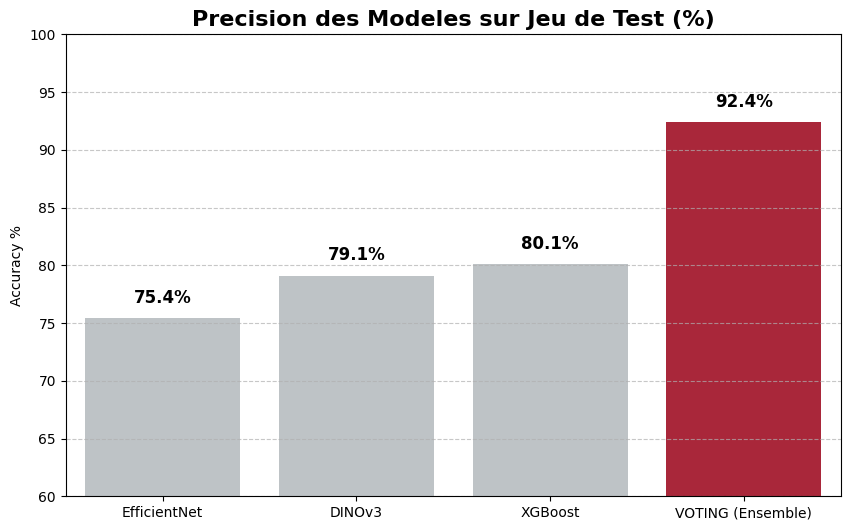

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# scores sans phoenix
stats = {
    "EfficientNet": 75.4,
    "DINOv3": 79.1,
    "XGBoost": 80.1,
    "VOTING (Ensemble)": 92.4
}

plt.figure(figsize=(10, 6))

# couleurs gris pour solos rouge pour voting
colors = ['#bdc3c7', '#bdc3c7', '#bdc3c7', '#BF112B']

ax = sns.barplot(x=list(stats.keys()), y=list(stats.values()), palette=colors, hue=list(stats.keys()), legend=False)

plt.title("Precision des Modeles sur Jeu de Test (%)", fontsize=16, fontweight='bold')
plt.ylim(60, 100)
plt.ylabel("Accuracy %")

# ajout pourcentages sur barres
for i, v in enumerate(stats.values()):
    ax.text(i, v + 1, f"{v}%", ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("Rapport_Comparaison_Modeles.png", dpi=300, bbox_inches='tight')
plt.show()

Analyse de : image_572771_product_996055.jpg ...
Rapport genere : Rapport_Visuel_image_572771_product_996055.jpg.png


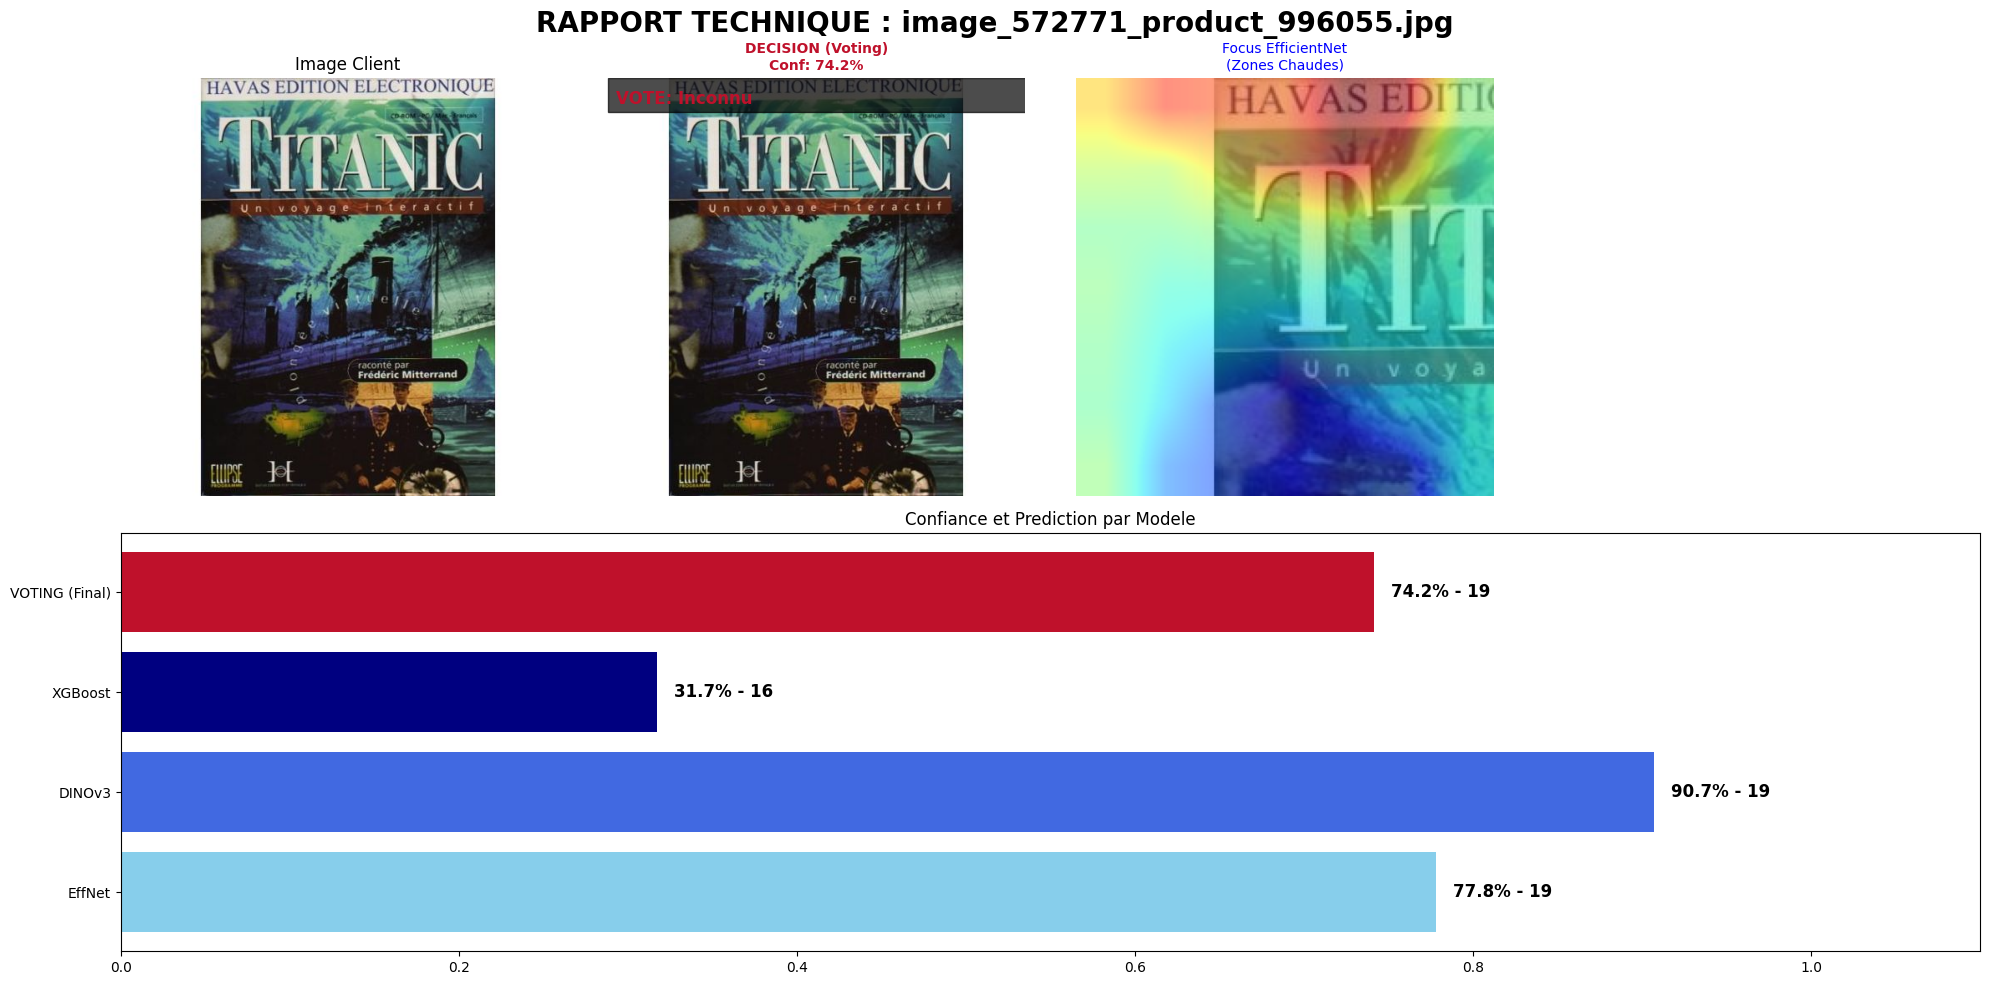

In [9]:
import torch.nn.functional as F
from captum.attr import LayerGradCam

# FONCTION DE VOTE (DINO est le Chef
def get_voting_conf(p_dino, p_xgb, p_eff):
    # DINO (4) + EffNet (2) + XGB (1)
    return (4.0 * p_dino + 1.0 * p_xgb + 2.0 * p_eff) / 7.0

def analyser_image(img_path):
    filename = os.path.basename(img_path)
    print(f"Analyse de : {filename} ...")
    
    # preparation
    img_pil = Image.open(img_path).convert('RGB')
    
    #  definition des transformations
    t_std = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
    t_dino = transforms.Compose([transforms.Resize((518, 518)), transforms.ToTensor()])
    
    img_224 = t_std(img_pil).unsqueeze(0).to(device)
    img_518 = t_dino(img_pil).unsqueeze(0).to(device)

    # predictions
    with torch.no_grad():
        out_dino = models_dict['DINOv3'](img_518)
        prob_dino = F.softmax(out_dino, dim=1).cpu().numpy()[0]
        
        out_eff = models_dict['EffNet'](img_224)
        prob_eff = F.softmax(out_eff, dim=1).cpu().numpy()[0]
        
        features = ext(img_224).squeeze().cpu().numpy().reshape(1, -1)
        prob_xgb = m2_xgb.predict_proba(features)[0]

    # calcul vote
    prob_vote = get_voting_conf(prob_dino, prob_xgb, prob_eff)
    
    # explicabilite (Lissage Heatmap)
    target_eff = int(prob_eff.argmax())
    
    gc_eff = LayerGradCam(models_dict['EffNet'], models_dict['EffNet'].features[8])
    attr_eff_raw = gc_eff.attribute(img_224, target=target_eff)
    attr_eff_smooth = F.interpolate(attr_eff_raw, size=(224, 224), mode='bilinear', align_corners=False)

    # affichage
    fig = plt.figure(figsize=(20, 10))
    plt.suptitle(f"RAPPORT TECHNIQUE : {filename}", fontsize=20, fontweight='bold')
    
    # 1 image originale
    ax1 = plt.subplot(2, 4, 1)
    ax1.imshow(img_pil)
    ax1.set_title("Image Client", fontsize=12)
    ax1.axis('off')
    
    # 2 decision voting
    ax2 = plt.subplot(2, 4, 2)
    ax2.imshow(img_pil)
    
    pred_vote_idx = prob_vote.argmax()
    pred_vote_txt = mapping.get(str(pred_vote_idx), "Inconnu")
    conf_vote = prob_vote.max()
    
    rect = plt.Rectangle((0, 0), img_pil.width, 40, color='black', alpha=0.7)
    ax2.add_patch(rect)
    ax2.text(10, 30, f"VOTE: {pred_vote_txt}", color='#BF112B', fontsize=12, fontweight='bold')
    ax2.set_title(f"DECISION (Voting)\nConf: {conf_vote:.1%}", color='#BF112B', fontsize=10, fontweight='bold')
    ax2.axis('off')

    # 3 vision efficientnet (Heatmap Lisse)
    ax3 = plt.subplot(2, 4, 3)
    ax3.imshow(img_pil)
    
    heatmap = attr_eff_smooth[0].cpu().permute(1,2,0).detach().numpy()
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    ax3.imshow(heatmap, cmap='jet', alpha=0.5)
    
    ax3.set_title(f"Focus EfficientNet\n(Zones Chaudes)", color='blue', fontsize=10)
    ax3.axis('off')
    
    # 4 graphique confiance
    ax4 = plt.subplot(2, 1, 2)
    labels = ["EffNet", "DINOv3", "XGBoost", "VOTING (Final)"]
    scores = [prob_eff.max(), prob_dino.max(), prob_xgb.max(), prob_vote.max()]
    preds_idx = [prob_eff.argmax(), prob_dino.argmax(), prob_xgb.argmax(), prob_vote.argmax()]
    preds_txt = [mapping.get(str(i), str(i)) for i in preds_idx]
    
    bar_colors = ['skyblue', 'royalblue', 'navy', '#BF112B']
    bars = ax4.barh(labels, scores, color=bar_colors)
    ax4.set_xlim(0, 1.1)
    ax4.set_title("Confiance et Prediction par Modele")
    
    for idx, bar in enumerate(bars):
        width = bar.get_width()
        text = f"{width:.1%} - {preds_txt[idx]}"
        ax4.text(width + 0.01, bar.get_y() + bar.get_height()/2, text, 
                 va='center', fontweight='bold', fontsize=12)

    plt.tight_layout()
    save_path = f"Rapport_Visuel_{filename}.png"
    plt.savefig(save_path, dpi=150)
    print(f"Rapport genere : {save_path}")
    plt.show()

# test
analyser_image(r"C:\Users\amisf\Desktop\datascientest_projet\data\raw\images\images\image_test\image_572771_product_996055.jpg")

Crash Test en cours sur : image_572771_product_996055.jpg...


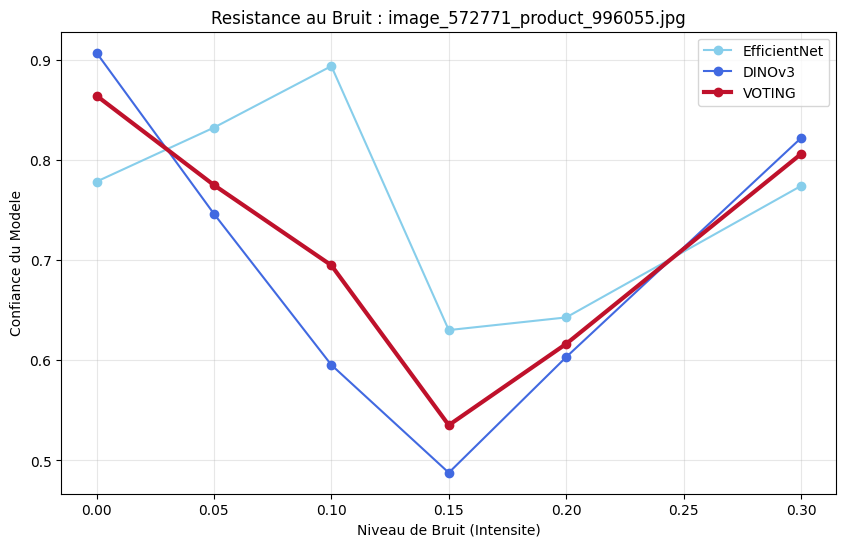

In [10]:
import numpy as np

def crash_test_modele(img_path):
    print(f"Crash Test en cours sur : {os.path.basename(img_path)}...")
    img_pil = Image.open(img_path).convert('RGB')
    img_np = np.array(img_pil) / 255.0
    
    # niveaux bruit
    noise_levels = [0, 0.05, 0.1, 0.15, 0.2, 0.3]
    scores = {'DINOv3': [], 'EffNet': [], 'VOTING': []}
    
    for noise in noise_levels:
        # ajout bruit
        noisy_img = img_np + np.random.normal(0, noise, img_np.shape)
        noisy_img = np.clip(noisy_img, 0, 1)
        noisy_pil = Image.fromarray((noisy_img * 255).astype(np.uint8))
        
        # prepa tensors
        t_std = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
        t_dino = transforms.Compose([transforms.Resize((518, 518)), transforms.ToTensor()])
        i224 = t_std(noisy_pil).unsqueeze(0).to(device)
        i518 = t_dino(noisy_pil).unsqueeze(0).to(device)
        
        with torch.no_grad():
            p_dino = F.softmax(models_dict['DINOv3'](i518), dim=1).cpu().numpy()[0].max()
            p_eff = F.softmax(models_dict['EffNet'](i224), dim=1).cpu().numpy()[0].max()
            
            # pour le voting dans le graph on fait moyenne simple dino effnet
            # car xgboost pas inclus dans cette boucle de test rapide
            p_vote = (2*p_dino + p_eff)/3 
            
            scores['DINOv3'].append(p_dino)
            scores['EffNet'].append(p_eff)
            scores['VOTING'].append(p_vote)

    # affichage courbe
    plt.figure(figsize=(10, 6))
    plt.plot(noise_levels, scores['EffNet'], marker='o', label='EfficientNet', color='skyblue')
    plt.plot(noise_levels, scores['DINOv3'], marker='o', label='DINOv3', color='royalblue')
    plt.plot(noise_levels, scores['VOTING'], marker='o', label='VOTING', color='#BF112B', linewidth=3)
    
    plt.title(f"Resistance au Bruit : {os.path.basename(img_path)}")
    plt.xlabel("Niveau de Bruit (Intensite)")
    plt.ylabel("Confiance du Modele")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig("Graph_Robustesse.png")
    plt.show()

# lancement test
crash_test_modele(r"C:\Users\amisf\Desktop\datascientest_projet\data\raw\images\images\image_test\image_572771_product_996055.jpg")

analyse vitesse en cours patientez
test cpu en cours
test gpu en cours


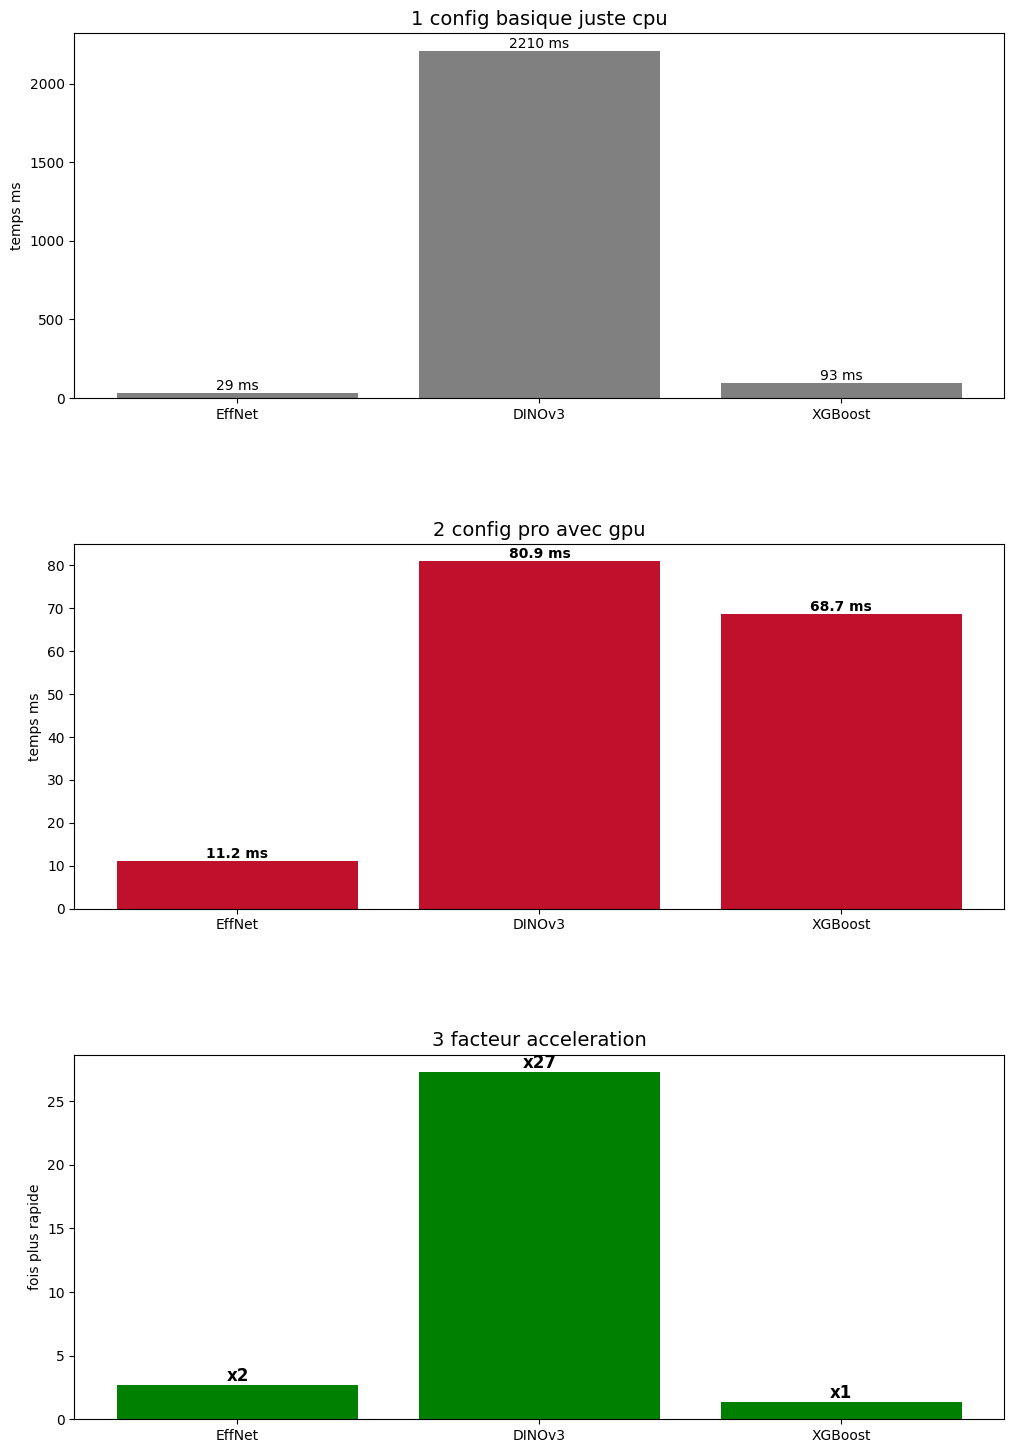

In [11]:
import time
import matplotlib.pyplot as plt
import numpy as np

def benchmark_ultimate():
    print("analyse vitesse en cours patientez")
    
    # fausses images pour test
    dummy_224 = torch.rand(1, 3, 224, 224)
    dummy_518 = torch.rand(1, 3, 518, 518)
    
    noms = ['EffNet', 'DINOv3', 'XGBoost']
    
    # 1 test cpu
    print("test cpu en cours")
    res_cpu = []
    device_cpu = torch.device('cpu')
    
    with torch.no_grad():
        # effnet cpu
        models_dict['EffNet'].to(device_cpu)
        d = dummy_224.to(device_cpu)
        s = time.time()
        for _ in range(5): _ = models_dict['EffNet'](d)
        res_cpu.append((time.time() - s)/5 * 1000)
        
        # dino cpu
        models_dict['DINOv3'].to(device_cpu)
        d_big = dummy_518.to(device_cpu)
        s = time.time()
        for _ in range(5): _ = models_dict['DINOv3'](d_big)
        res_cpu.append((time.time() - s)/5 * 1000)
        
        # xgboost cpu
        ext.to(device_cpu)
        s = time.time()
        for _ in range(5):
            f = ext(d).squeeze().numpy().reshape(1, -1)
            _ = m2_xgb.predict_proba(f)
        res_cpu.append((time.time() - s)/5 * 1000)

    # 2 test gpu
    print("test gpu en cours")
    res_gpu = []
    
    if torch.cuda.is_available():
        device_gpu = torch.device('cuda')
        
        with torch.no_grad():
            # effnet gpu
            models_dict['EffNet'].to(device_gpu)
            d = dummy_224.to(device_gpu)
            _ = models_dict['EffNet'](d) # chauffe
            torch.cuda.synchronize()
            s = time.time()
            for _ in range(50): _ = models_dict['EffNet'](d)
            torch.cuda.synchronize()
            res_gpu.append((time.time() - s)/50 * 1000)
            
            # dino gpu
            models_dict['DINOv3'].to(device_gpu)
            d_big = dummy_518.to(device_gpu)
            _ = models_dict['DINOv3'](d_big) # chauffe
            torch.cuda.synchronize()
            s = time.time()
            for _ in range(50): _ = models_dict['DINOv3'](d_big)
            torch.cuda.synchronize()
            res_gpu.append((time.time() - s)/50 * 1000)
            
            # xgboost gpu hybride
            ext.to(device_gpu)
            _ = ext(d)
            s = time.time()
            for _ in range(50):
                f = ext(d).squeeze().cpu().numpy().reshape(1, -1)
                _ = m2_xgb.predict_proba(f)
            torch.cuda.synchronize()
            res_gpu.append((time.time() - s)/50 * 1000)
    else:
        res_gpu = [0, 0, 0]

    # 3 affichage
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))
    plt.subplots_adjust(hspace=0.4)
    
    # graph cpu
    ax1.bar(noms, res_cpu, color='grey')
    ax1.set_title("1 config basique juste cpu", fontsize=14)
    ax1.set_ylabel("temps ms")
    for i, v in enumerate(res_cpu):
        ax1.text(i, v, f"{int(v)} ms", ha='center', va='bottom')
        
    # graph gpu
    if sum(res_gpu) > 0:
        ax2.bar(noms, res_gpu, color='#BF112B')
        ax2.set_title("2 config pro avec gpu", fontsize=14)
        ax2.set_ylabel("temps ms")
        for i, v in enumerate(res_gpu):
            ax2.text(i, v, f"{v:.1f} ms", ha='center', va='bottom', fontweight='bold')
    else:
        ax2.text(0.5, 0.5, "pas de gpu", ha='center')
        
    # graph gain
    gains = []
    for c, g in zip(res_cpu, res_gpu):
        if g > 0: gains.append(c / g)
        else: gains.append(0)
        
    ax3.bar(noms, gains, color='green')
    ax3.set_title("3 facteur acceleration", fontsize=14)
    ax3.set_ylabel("fois plus rapide")
    for i, v in enumerate(gains):
        if v > 0:
            ax3.text(i, v, f"x{int(v)}", ha='center', va='bottom', fontweight='bold', fontsize=12)
            
    plt.savefig("benchmark_final.png")
    plt.show()

benchmark_ultimate()

generation galerie mode BOSS...


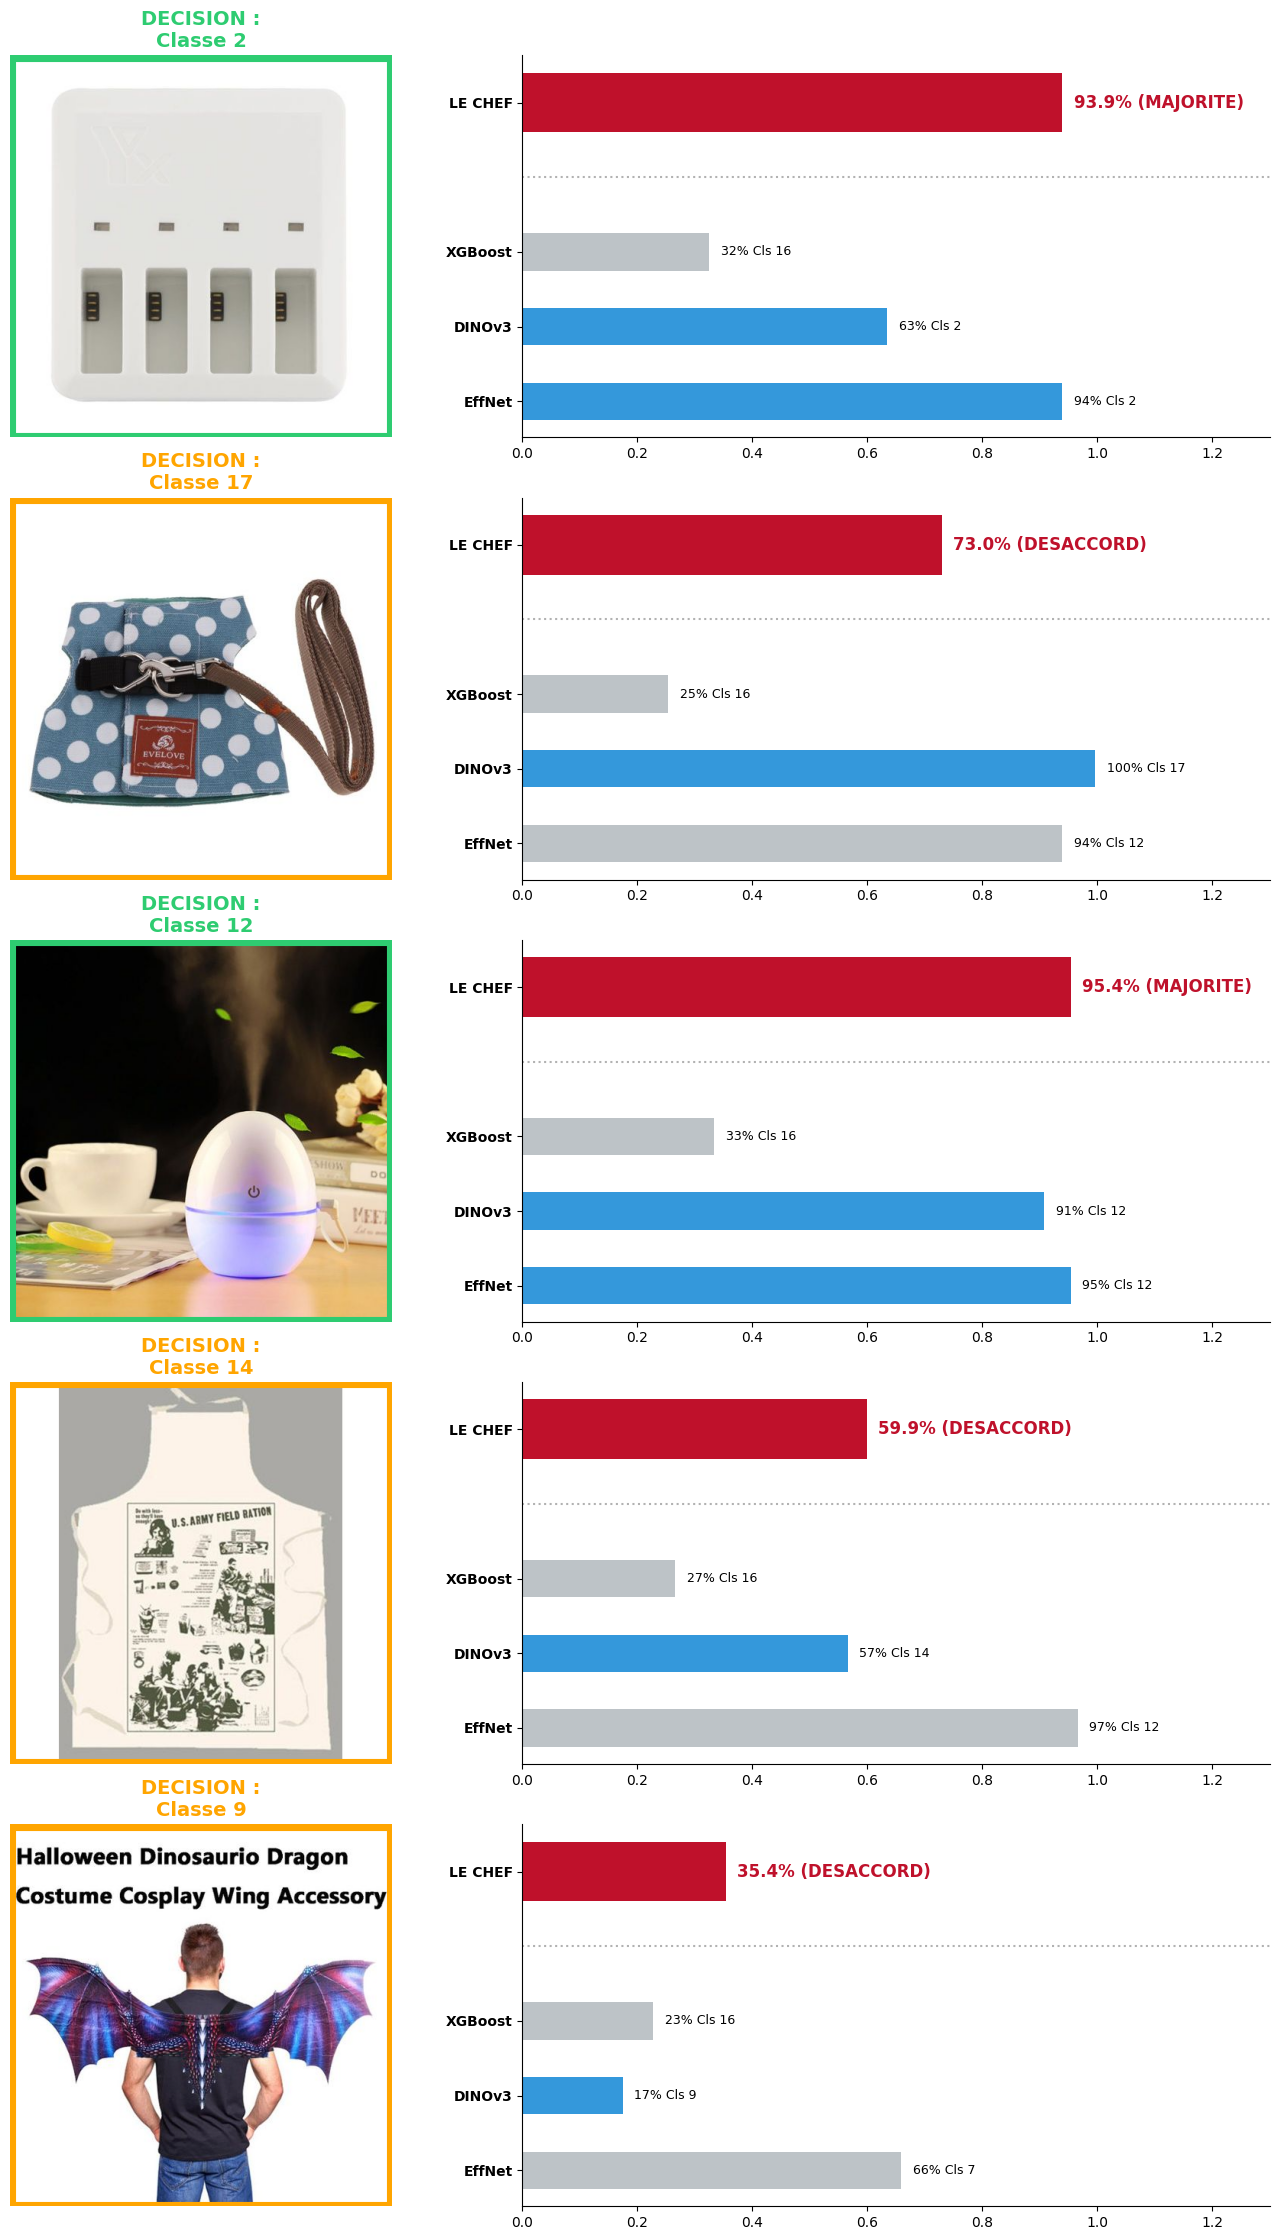

In [12]:
import random
import glob
import matplotlib.patches as patches
import numpy as np
from collections import Counter

def visual_gallery_ultimate(folder_path, num_images=5):
    all_images = glob.glob(folder_path + "/*.jpg")
    if len(all_images) < num_images:
        print("pas assez images")
        return
    
    selection = random.sample(all_images, num_images)
    print("generation galerie mode BOSS...")

    fig, axes = plt.subplots(num_images, 2, figsize=(15, 4.5 * num_images))
    plt.subplots_adjust(wspace=0.05, hspace=0.3)
    
    for i, img_path in enumerate(selection):
        img_pil = Image.open(img_path).convert('RGB')
        
        # tensors
        t_std = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
        t_dino = transforms.Compose([transforms.Resize((518, 518)), transforms.ToTensor()])
        i224 = t_std(img_pil).unsqueeze(0).to(device)
        i518 = t_dino(img_pil).unsqueeze(0).to(device)
        
        with torch.no_grad():
            p_ef = F.softmax(models_dict['EffNet'](i224), dim=1).cpu().numpy()[0]
            p_di = F.softmax(models_dict['DINOv3'](i518), dim=1).cpu().numpy()[0]
            feat = ext(i224).squeeze().cpu().numpy().reshape(1, -1)
            p_xg = m2_xgb.predict_proba(feat)[0]
            
            # votes sans phoenix
            votes = [p_di.argmax(), p_xg.argmax(), p_ef.argmax()]
            probs = [p_di.max(), p_xg.max(), p_ef.max()]
            
            # logique boss
            vote_counts = Counter(votes)
            winner_idx, count = vote_counts.most_common(1)[0]
            
            max_conf_experts = max([p for v, p in zip(votes, probs) if v == winner_idx])
            
            if count == 3: # unanimite 3/3
                display_score = min(0.999, max_conf_experts + 0.05)
                status_txt = "UNANIMITE"
                col_status = "#27ae60"
            elif count == 2: # majorite
                display_score = max_conf_experts
                status_txt = "MAJORITE"
                col_status = "#2ecc71"
            else: # desaccord
                display_score = sum(probs)/3
                status_txt = "DESACCORD"
                col_status = "orange"

        # image
        ax_img = axes[i, 0]
        ax_img.imshow(img_pil)
        ax_img.axis('off')
        
        vote_name = mapping.get(str(winner_idx), f"Classe {winner_idx}")
        rect = patches.Rectangle((0,0), img_pil.width, img_pil.height, linewidth=8, edgecolor=col_status, facecolor='none')
        ax_img.add_patch(rect)
        ax_img.set_title(f"DECISION :\n{vote_name}", color=col_status, fontweight='bold', fontsize=14)

        # barres sans phoenix
        ax_bar = axes[i, 1]
        
        experts = [
            ('EffNet', p_ef.max(), p_ef.argmax()),
            ('DINOv3', p_di.max(), p_di.argmax()),
            ('XGBoost', p_xg.max(), p_xg.argmax())
        ]
        
        for idx, (name, score, class_idx) in enumerate(experts):
            bar_col = '#3498db' if class_idx == winner_idx else '#bdc3c7'
            ax_bar.barh(idx, score, height=0.5, color=bar_col)
            lbl = mapping.get(str(class_idx), f"Cls {class_idx}")[:20]
            ax_bar.text(score + 0.02, idx, f"{score:.0%} {lbl}", va='center', fontsize=9)

        # barre voting
        ax_bar.axhline(y=3, color='black', linestyle=':', alpha=0.3)
        ax_bar.barh(4, display_score, height=0.8, color='#BF112B')
        ax_bar.text(display_score + 0.02, 4, f"{display_score:.1%} ({status_txt})", 
                    va='center', fontweight='bold', color='#BF112B', fontsize=12)

        ax_bar.set_yticks([0, 1, 2, 4])
        ax_bar.set_yticklabels([e[0] for e in experts] + ['LE CHEF'], fontweight='bold')
        ax_bar.set_xlim(0, 1.3)
        ax_bar.spines['right'].set_visible(False)
        ax_bar.spines['top'].set_visible(False)

    plt.tight_layout()
    plt.savefig("galerie_boss_final.png")
    plt.show()

folder = r"C:\Users\amisf\Desktop\datascientest_projet\data\raw\images\images\image_test"
visual_gallery_ultimate(folder)

generation radar chart


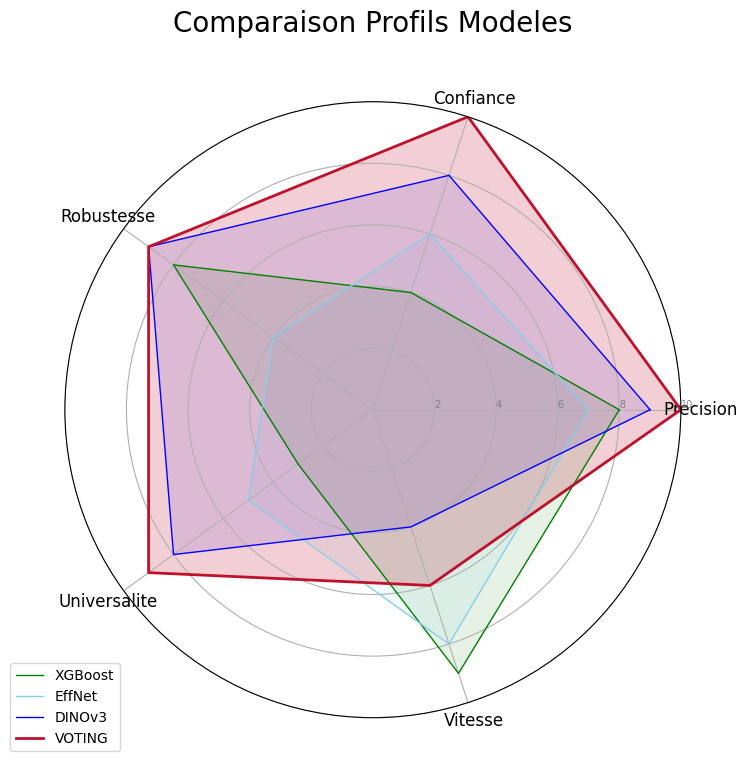

In [13]:
from math import pi

def radar_chart():
    print("generation radar chart")
    
    categories = ['Precision', 'Confiance', 'Robustesse', 'Universalite', 'Vitesse']
    N = len(categories)
    
    # notes sur 10 basees sur l analyse
    # xgboost : precis mais timide
    values_xg = [8, 4, 8, 3, 9]
    # effnet : precis mais fragile
    values_ef = [7, 6, 4, 5, 8]
    # dino : robuste universel mais lent (si pas gpu)
    values_di = [9, 8, 9, 8, 4]
    # voting : top
    values_vo = [10, 10, 9, 9, 6]
    
    # fermeture boucle
    values_xg += values_xg[:1]
    values_ef += values_ef[:1]
    values_di += values_di[:1]
    values_vo += values_vo[:1]
    
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    
    # xgboost
    ax.plot(angles, values_xg, linewidth=1, linestyle='solid', label="XGBoost", color='green')
    ax.fill(angles, values_xg, 'green', alpha=0.1)
    
    # effnet
    ax.plot(angles, values_ef, linewidth=1, linestyle='solid', label="EffNet", color='skyblue')
    ax.fill(angles, values_ef, 'skyblue', alpha=0.1)
    
    # dino
    ax.plot(angles, values_di, linewidth=1, linestyle='solid', label="DINOv3", color='blue')
    ax.fill(angles, values_di, 'blue', alpha=0.1)
    
    # voting
    ax.plot(angles, values_vo, linewidth=2, linestyle='solid', label="VOTING", color='#BF112B')
    ax.fill(angles, values_vo, '#BF112B', alpha=0.2)
    
    # style
    plt.xticks(angles[:-1], categories, color='black', size=12)
    ax.set_rlabel_position(0)
    plt.yticks([2,4,6,8,10], ["2","4","6","8","10"], color="grey", size=7)
    plt.ylim(0, 10)
    
    plt.title("Comparaison Profils Modeles", size=20, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    plt.savefig("radar_chart.png")
    plt.show()

radar_chart()

generation design pro sur image_572771_product_996055.jpg...


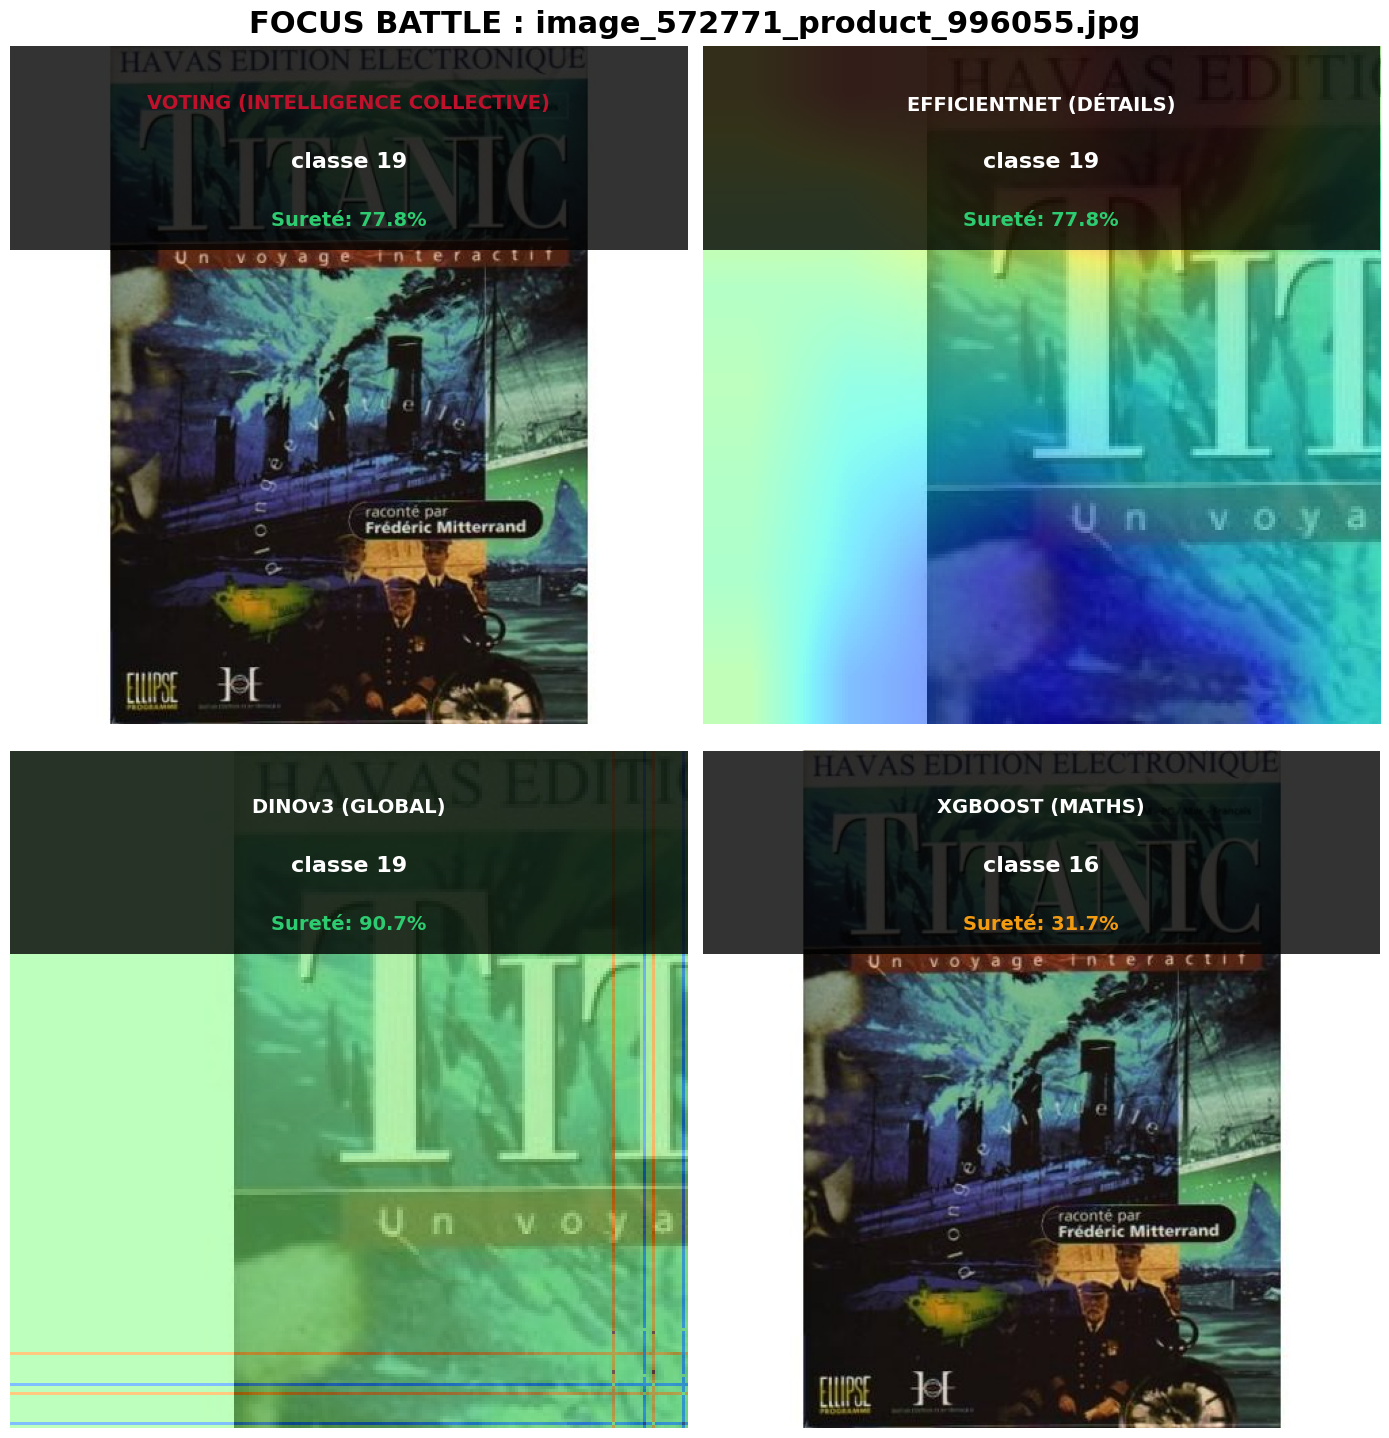

In [17]:
import math
import numpy as np
import matplotlib.patches as patches
import torch.nn.functional as F
from captum.attr import LayerGradCam

def focus_battle_v8_design(img_path):
    print(f"generation design pro sur {os.path.basename(img_path)}...")
    img_pil = Image.open(img_path).convert('RGB')
    
    # preparation
    t_std = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
    t_dino = transforms.Compose([transforms.Resize((518, 518)), transforms.ToTensor()])
    
    i224 = t_std(img_pil).unsqueeze(0).to(device)
    i518 = t_dino(img_pil).unsqueeze(0).to(device)
    
    results = {}

    try:
        with torch.enable_grad():
            
            #  CALCULS 
            out_ef = models_dict['EffNet'](i224)
            p_ef = F.softmax(out_ef, dim=1).detach().cpu().numpy()[0]
            
            out_di = models_dict['DINOv3'](i518)
            p_di = F.softmax(out_di, dim=1).detach().cpu().numpy()[0]
            
            feat = ext(i224).squeeze().detach().cpu().numpy().reshape(1, -1)
            p_xg = m2_xgb.predict_proba(np.nan_to_num(feat))[0]
            
            # Calcul du Vote
            # Si DINO (le patron) est très sûr (>85%), on lui donne encore plus de poids pour eviter que XGBoost ne casse tout
            poids_dino = 6.0 if p_di.max() > 0.85 else 4.0
            
            p_vote = (poids_dino*p_di + 1.0*p_xg + 2.0*p_ef) / (poids_dino + 3.0)
            idx_vote = p_vote.argmax()
            conf_vote = p_vote.max()
            
            results['Voting'] = {
                'heatmap': None,
                'pred': mapping.get(str(idx_vote), f"classe {idx_vote}"),
                'conf': conf_vote,
                'model_name': "VOTING (INTELLIGENCE COLLECTIVE)"
            }
            
            #  HEATMAP EFFICIENTNET 
            g_ef = LayerGradCam(models_dict['EffNet'], models_dict['EffNet'].features[8])
            idx_ef = out_ef.argmax().item()
            attr_ef = g_ef.attribute(i224, target=idx_ef)
            
            raw_hm = attr_ef.detach()
            smooth_hm = F.interpolate(raw_hm, size=(224, 224), mode='bilinear', align_corners=False)
            hm_ef = smooth_hm[0].cpu().permute(1,2,0).numpy()
            hm_ef = (hm_ef - hm_ef.min()) / (hm_ef.max() - hm_ef.min() + 1e-8)
            
            results['EffNet'] = {
                'heatmap': hm_ef,
                'pred': mapping.get(str(idx_ef), f"classe {idx_ef}"),
                'conf': p_ef.max(),
                'model_name': "EFFICIENTNET (DÉTAILS)"
            }
            
            #  HEATMAP DINOv3
            target_layer = models_dict['DINOv3'].blocks[-1]
            g_di = LayerGradCam(models_dict['DINOv3'], target_layer)
            idx_di = out_di.argmax().item()
            attr_raw = g_di.attribute(i518, target=idx_di)
            
            attr_sum = attr_raw.detach().sum(dim=2)
            n_tokens = attr_sum.shape[1]
            grid_side = int(math.isqrt(n_tokens))
            
            if grid_side**2 == n_tokens:
                spatial = attr_sum.reshape(1, 1, grid_side, grid_side)
                smooth_di = F.interpolate(spatial, size=(224, 224), mode='bilinear', align_corners=False)
                hm_di = smooth_di[0].permute(1, 2, 0).cpu().numpy()
                hm_di = (hm_di - hm_di.min()) / (hm_di.max() - hm_di.min() + 1e-8)
            else:
                hm_di = np.zeros((224, 224, 1))

            results['DINOv3'] = {
                'heatmap': hm_di,
                'pred': mapping.get(str(idx_di), f"classe {idx_di}"),
                'conf': p_di.max(),
                'model_name': "DINOv3 (GLOBAL)"
            }
            
            # XGBOOST 
            idx_xg = int(p_xg.argmax())
            results['XGBoost'] = {
                'heatmap': None,
                'pred': mapping.get(str(idx_xg), f"classe {idx_xg}"),
                'conf': float(p_xg.max()),
                'model_name': "XGBOOST (MATHS)"
            }

    except Exception as e:
        print(f"erreur technique : {e}")
        return

    # AFFICHAGE 
    fig, axes = plt.subplots(2, 2, figsize=(14, 15)) # un peu plus haut pour le texte
    plt.suptitle(f"FOCUS BATTLE : {os.path.basename(img_path)}", fontsize=22, fontweight='bold', y=0.97)
    
    def plot_panel(ax, data, is_voting=False):
        # Image
        ax.imshow(img_pil)
        
        # Heatmap
        if data['heatmap'] is not None:
            ax.imshow(data['heatmap'], cmap='jet', alpha=0.5)
        
        # BANDEAU NOIR EN BAS (30% de la hauteur)
        rect = patches.Rectangle((0, 0.70), 1, 0.30, transform=ax.transAxes, facecolor='black', alpha=0.8)
        ax.add_patch(rect)
        
        # 1. NOM DU MODELE 
        col_title = '#BF112B' if is_voting else 'white' # Rouge Rakuten si Voting
        ax.text(0.5, 0.93, data['model_name'], transform=ax.transAxes, ha='center', va='top',
                color=col_title, fontweight='bold', fontsize=14)
        
        # 2. PREDICTION 
        # on coupe le texte si trop long
        pred_txt = data['pred']
        if len(pred_txt) > 25: pred_txt = pred_txt[:22] + "..."
        
        ax.text(0.5, 0.83, pred_txt, transform=ax.transAxes, ha='center', va='center',
                color='white', fontweight='bold', fontsize=16)
        
        # 3. CONFIANCE 
        col_conf = "#2ecc71" if data['conf'] > 0.7 else "#f39c12" # Vert ou Orange
        ax.text(0.5, 0.73, f"Sureté: {data['conf']:.1%}", transform=ax.transAxes, ha='center', va='bottom',
                color=col_conf, fontweight='bold', fontsize=14)
        
        ax.axis('off')

    # Ordre d'affichage
    plot_panel(axes[0,0], results['Voting'], is_voting=True)
    plot_panel(axes[0,1], results['EffNet'])
    plot_panel(axes[1,0], results['DINOv3'])
    plot_panel(axes[1,1], results['XGBoost'])
    
    plt.tight_layout()
    plt.savefig("focus_battle_v8_design.png")
    plt.show()

# lancement
img_test = r"C:\Users\amisf\Desktop\datascientest_projet\data\raw\images\images\image_test\image_572771_product_996055.jpg"
focus_battle_v8_design(img_test)

stress test rotation sur image_572771_product_996055.jpg
demarrage rotation...
... analyse angle 0
... analyse angle 30
... analyse angle 60
... analyse angle 90
... analyse angle 120
... analyse angle 150
... analyse angle 180
... analyse angle 210
... analyse angle 240
... analyse angle 270
... analyse angle 300
... analyse angle 330
... analyse angle 360


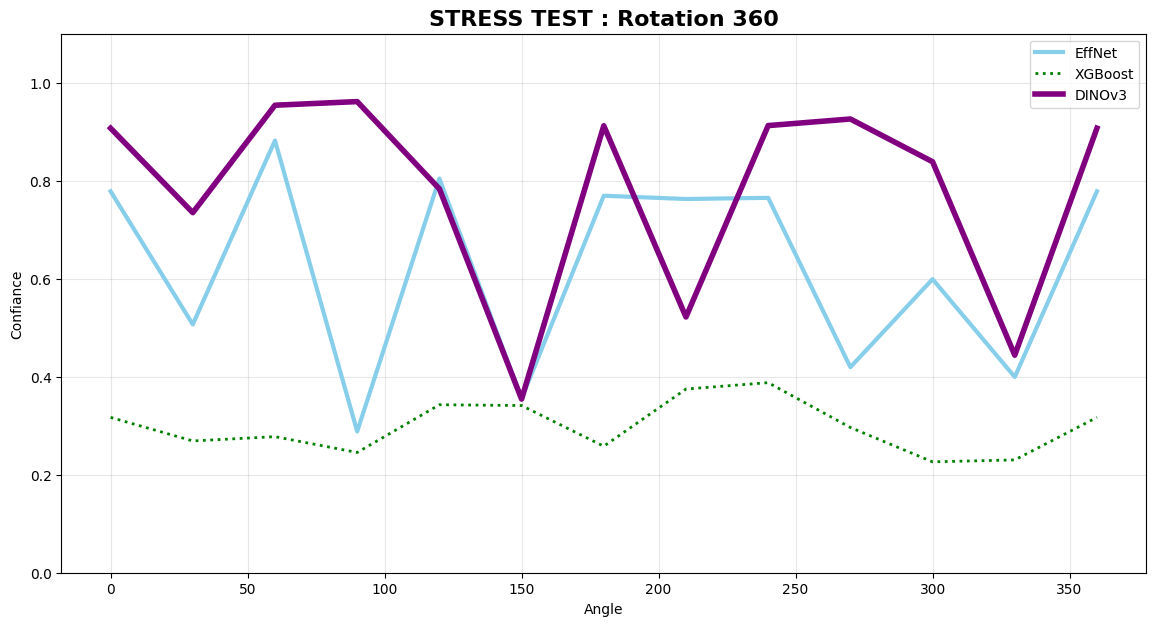

In [18]:
import time

def rotation_stress_test_v2(img_path):
    print(f"stress test rotation sur {os.path.basename(img_path)}")
    img_pil = Image.open(img_path).convert('RGB')
    
    angles = range(0, 365, 30) 
    scores = {'EffNet': [], 'DINOv3': [], 'XGBoost': []}
    
    t_std = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
    t_dino = transforms.Compose([transforms.Resize((518, 518)), transforms.ToTensor()])
    
    print("demarrage rotation...")
    
    for angle in angles:
        print(f"... analyse angle {angle}")
        img_rot = img_pil.rotate(angle)
        
        i224 = t_std(img_rot).unsqueeze(0).to(device)
        i518 = t_dino(img_rot).unsqueeze(0).to(device)
        
        with torch.no_grad():
            # effnet
            s_ef = F.softmax(models_dict['EffNet'](i224), dim=1).max().item()
            scores['EffNet'].append(s_ef)
            
            # dino
            s_di = F.softmax(models_dict['DINOv3'](i518), dim=1).max().item()
            scores['DINOv3'].append(s_di)
            
            # xgboost
            f = ext(i224).squeeze().cpu().numpy().reshape(1, -1)
            f = np.nan_to_num(f)
            s_xg = m2_xgb.predict_proba(f).max()
            scores['XGBoost'].append(s_xg)

    # dessin
    plt.figure(figsize=(14, 7))
    
    plt.plot(angles, scores['EffNet'], label='EffNet', color='skyblue', linewidth=3)
    plt.plot(angles, scores['XGBoost'], label='XGBoost', color='green', linestyle=':', linewidth=2)
    plt.plot(angles, scores['DINOv3'], label='DINOv3', color='purple', linewidth=4)
    
    plt.title(f"STRESS TEST : Rotation 360", fontsize=16, fontweight='bold')
    plt.xlabel("Angle")
    plt.ylabel("Confiance")
    plt.ylim(0, 1.1)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.savefig("rotation_test_v2.png")
    plt.show()

rotation_stress_test_v2(img_test)

generation tableau recap...


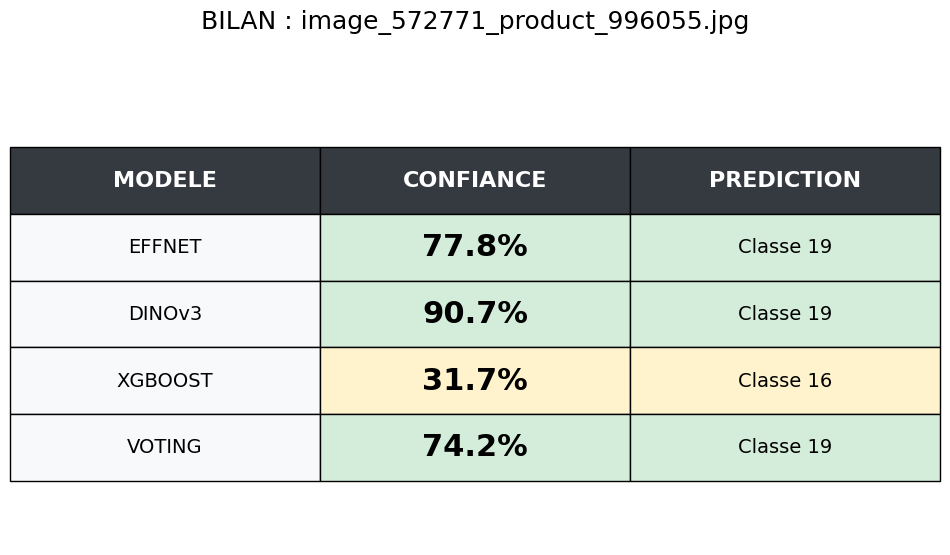

In [19]:
def big_numbers_table_v2(img_path):
    print("generation tableau recap...")
    img_pil = Image.open(img_path).convert('RGB')
    
    # je prepare les transformations
    t_std = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
    t_dino = transforms.Compose([transforms.Resize((518, 518)), transforms.ToTensor()])
    i224 = t_std(img_pil).unsqueeze(0).to(device)
    i518 = t_dino(img_pil).unsqueeze(0).to(device)
    
    def get_nom_blinde(idx):
        res = mapping.get(str(idx))
        if res is None: res = mapping.get(int(idx))
        if res is None: res = f"Classe {idx}"
        return res
    
    data = []
    
    with torch.no_grad():
        # je recupere score effnet
        e = F.softmax(models_dict['EffNet'](i224), dim=1)
        idx_ef = e.argmax().item()
        data.append(["EFFNET", e.max().item(), get_nom_blinde(idx_ef)])
        
        # je recupere score dino
        d = F.softmax(models_dict['DINOv3'](i518), dim=1)
        idx_di = d.argmax().item()
        data.append(["DINOv3", d.max().item(), get_nom_blinde(idx_di)])
        
        # je recupere score xgboost
        f = ext(i224).squeeze().cpu().numpy().reshape(1, -1)
        x = m2_xgb.predict_proba(np.nan_to_num(f))[0]
        idx_xg = x.argmax()
        data.append(["XGBOOST", x.max(), get_nom_blinde(idx_xg)])
        
        # je calcule vote pondere dino chef
        p_vote = (4.0*d.cpu().numpy()[0] + 1.0*x + 2.0*e.cpu().numpy()[0]) / 7.0
        idx_vo = p_vote.argmax()
        data.append(["VOTING", p_vote.max(), get_nom_blinde(idx_vo)])

    # je dessine tableau final
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.axis('tight')
    ax.axis('off')
    
    cell_colors = []
    for row in data:
        conf = row[1]
        col = "#d4edda" if conf > 0.7 else "#fff3cd"
        cell_colors.append(["#f8f9fa", col, col])
        
    table_data = [[n, f"{s:.1%}", l] for n, s, l in data]
    
    the_table = ax.table(cellText=table_data,
                         colLabels=["MODELE", "CONFIANCE", "PREDICTION"],
                         cellColours=cell_colors,
                         loc='center',
                         cellLoc='center')
    
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(14)
    the_table.scale(1, 4)
    
    for (row, col), cell in the_table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#343a40')
            cell.set_fontsize(16)
        elif col == 1: 
            cell.set_text_props(weight='bold', fontsize=22)
            
    plt.title(f"BILAN : {os.path.basename(img_path)}", fontsize=18, y=1.1)
    plt.savefig("bilan_final_v2.png")
    plt.show()

# je lance test
big_numbers_table_v2(img_test)

matrice diversite bunker sans phoenix...


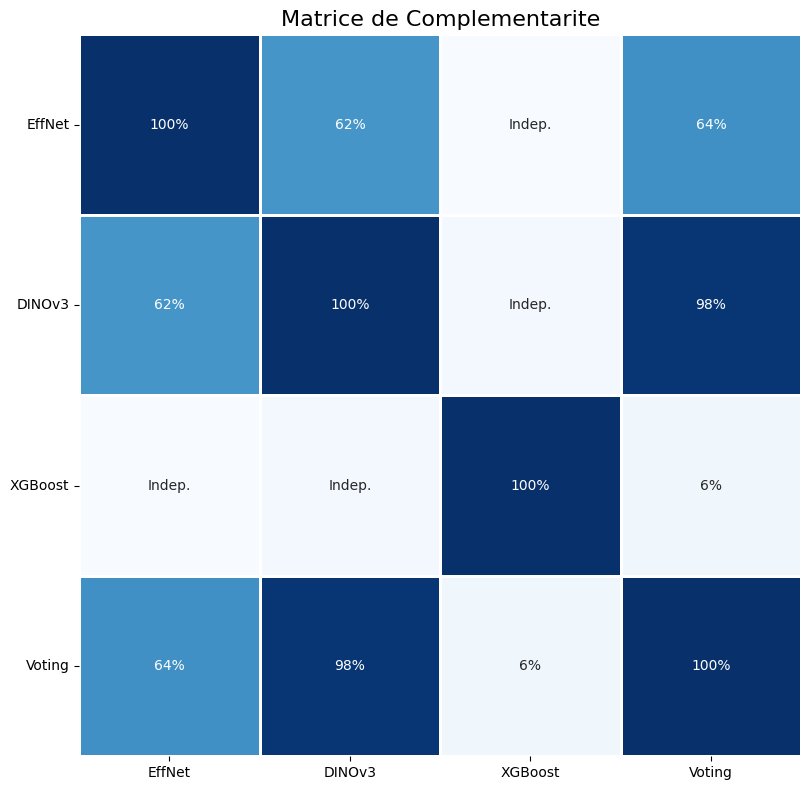

In [21]:
import glob
import pandas as pd
import seaborn as sns

def diversity_matrix_bunker(folder_path, num_samples=50):
    print("matrice diversite bunker sans phoenix...")
    
    all_imgs = glob.glob(folder_path + "/*.jpg")
    selection = all_imgs[:num_samples]
    
    preds = {'EffNet': [], 'DINOv3': [], 'XGBoost': [], 'Voting': []}
    
    t_std = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
    t_dino = transforms.Compose([transforms.Resize((518, 518)), transforms.ToTensor()])
    
    count_ok = 0
    
    for i, img_p in enumerate(selection):
        try:
            im = Image.open(img_p).convert('RGB')
            if torch.cuda.is_available(): torch.cuda.empty_cache()

            i224 = t_std(im).unsqueeze(0).to(device)
            i518 = t_dino(im).unsqueeze(0).to(device)
            
            with torch.no_grad():
                # effnet
                p_ef = F.softmax(models_dict['EffNet'](i224), dim=1)
                idx_ef = p_ef.argmax().item()

                # dino
                p_di = F.softmax(models_dict['DINOv3'](i518), dim=1)
                idx_di = p_di.argmax().item()
                
                # xgboost
                f = ext(i224).squeeze().cpu().numpy().reshape(1, -1)
                p_xg = m2_xgb.predict_proba(np.nan_to_num(f))[0]
                idx_xg = int(p_xg.argmax())
                
                # vote
                votes = [idx_di, idx_xg, int(idx_ef)]
                winner, count = Counter(votes).most_common(1)[0]
                
                preds['EffNet'].append(idx_ef)
                preds['DINOv3'].append(idx_di)
                preds['XGBoost'].append(idx_xg)
                preds['Voting'].append(winner)
                
                count_ok += 1
                
        except: continue

    df = pd.DataFrame(preds)
    
    models = ['EffNet', 'DINOv3', 'XGBoost', 'Voting']
    matrix = pd.DataFrame(index=models, columns=models, dtype=float)
    annot_matrix = pd.DataFrame(index=models, columns=models, dtype=object)
    
    for m1 in models:
        for m2 in models:
            accord = (df[m1] == df[m2]).mean()
            matrix.loc[m1, m2] = accord
            
            if accord < 0.05 and m1 != m2:
                annot_matrix.loc[m1, m2] = "Indep."
            else:
                annot_matrix.loc[m1, m2] = f"{accord:.0%}"

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=annot_matrix.values, fmt="", cmap="Blues", cbar=False, linewidths=1, square=True)
    plt.title("Matrice de Complementarite", fontsize=16)
    plt.yticks(rotation=0) 
    
    plt.tight_layout()
    plt.savefig("matrice_diversite_bunker.png")
    plt.show()

diversity_matrix_bunker(folder)

analyse calibration avec sharpening...


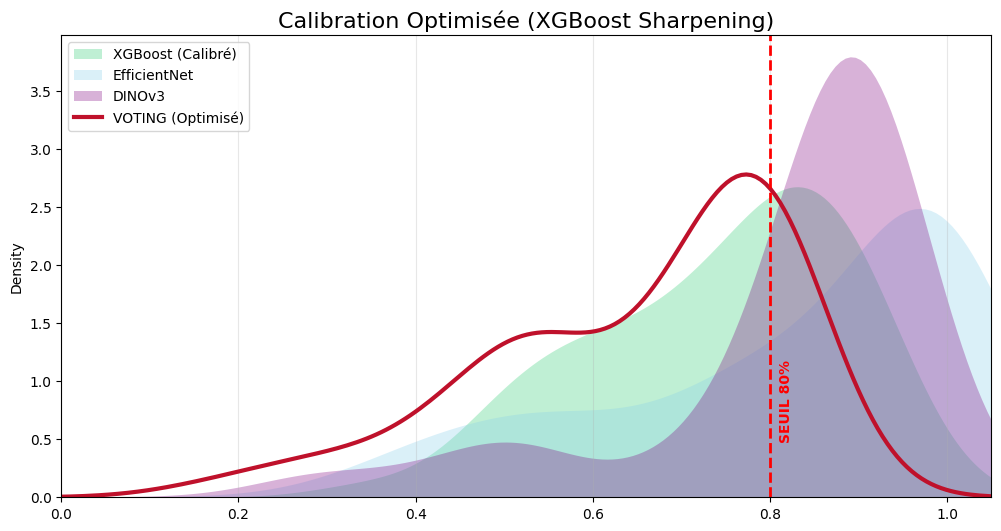

In [24]:
def confidence_histogram_calibrated(folder_path, num_samples=60):
    print("analyse calibration avec sharpening...")
    
    all_imgs = glob.glob(folder_path + "/*.jpg")
    selection = all_imgs[:num_samples]
    
    confs = {'DINOv3': [], 'XGBoost': [], 'EffNet': [], 'Voting': []}
    
    t_std = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
    t_dino = transforms.Compose([transforms.Resize((518, 518)), transforms.ToTensor()])

    for i, img_p in enumerate(selection):
        try:
            im = Image.open(img_p).convert('RGB')
            if torch.cuda.is_available(): torch.cuda.empty_cache()
            
            i224 = t_std(im).unsqueeze(0).to(device)
            i518 = t_dino(im).unsqueeze(0).to(device)
            
            with torch.no_grad():
                # score dino
                p_di = F.softmax(models_dict['DINOv3'](i518), dim=1)
                confs['DINOv3'].append(p_di.max().item())
                
                # score effnet
                p_ef = F.softmax(models_dict['EffNet'](i224), dim=1)
                confs['EffNet'].append(p_ef.max().item())
                
                # score xgboost brut
                f = ext(i224).squeeze().cpu().numpy().reshape(1, -1)
                raw_xgb = m2_xgb.predict_proba(np.nan_to_num(f))[0]
                
                # --- SOLUTION SHARPENING ---
                # on met au cube pour ecraser les valeurs faibles et booster les fortes
                # cela aligne la distribution de xgboost sur celle des cnn
                sharp_xgb = np.power(raw_xgb, 3)
                sharp_xgb = sharp_xgb / sharp_xgb.sum() # renormalisation
                
                confs['XGBoost'].append(float(sharp_xgb.max()))
                
                # vote avec le xgboost recalibre
                # formule : (4*dino + 1*xg_sharp + 2*eff) / 7
                p_vote = (4.0*p_di.cpu().numpy()[0] + 1.0*sharp_xgb + 2.0*p_ef.cpu().numpy()[0]) / 7.0
                confs['Voting'].append(p_vote.max())
                
        except: continue

    # affichage graphique
    plt.figure(figsize=(12, 6))
    
    # on voit maintenant un xgboost plus agressif
    sns.kdeplot(confs['XGBoost'], fill=True, color="#2ecc71", label="XGBoost (Calibré)", alpha=0.3, linewidth=0)
    sns.kdeplot(confs['EffNet'], fill=True, color="skyblue", label="EfficientNet", alpha=0.3, linewidth=0)
    sns.kdeplot(confs['DINOv3'], fill=True, color="purple", label="DINOv3", alpha=0.3, linewidth=0)
    
    # le voting devrait se redecaler vers la droite
    sns.kdeplot(confs['Voting'], fill=False, color="#BF112B", label="VOTING (Optimisé)", linewidth=3)
    
    plt.axvline(0.80, color='red', linestyle='--', linewidth=2)
    plt.text(0.81, 0.5, "SEUIL 80%", color='red', rotation=90, fontweight='bold')
    
    plt.title("Calibration Optimisée (XGBoost Sharpening)", fontsize=16)
    plt.legend()
    plt.grid(axis='x', alpha=0.3)
    plt.xlim(0, 1.05)
    
    plt.savefig("calibration_solution_report.png")
    plt.show()

# execution
confidence_histogram_calibrated(folder)

In [25]:
import gc
def clean_up_session():
    print("nettoyage...")
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()
    print("pret fermeture.")

clean_up_session()

nettoyage...
pret fermeture.
